In [1]:
import sys
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
import scipy.stats
plt.style.use(mplhep.style.CMS)
import matplotlib.font_manager
mpl.rcParams.update(
    {'font.size': 18,
     'font.family': 'sans-serif',
     'legend.fontsize': 14,
     'axes.labelsize': 18,
     'xtick.labelsize': 14,
     'ytick.labelsize': 14
    }
    )

['/cvmfs/sft.cern.ch/lcg/releases/condor/8.9.11-e1651/x86_64-centos7-gcc11-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python39.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/lib-dynload', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/extensions', '/scratch/malvesga/.ipyth

In [2]:
from processing import lumi_periods_2017, lumi_periods_2018

#lepton_type = 'muon'
lepton_type = 'electron'

# data_sample = '2017'
data_sample = '2018'

save_figures = False

{'muon': {'2017B': 4.799881474, '2017C1': 5.785813941, '2017C2': 3.786684323, '2017D': 4.247682053, '2017E': 9.312832062, '2017F1': 1.738905587, '2017F2': 8.125575961, '2017F3': 3.674404546}, 'electron': {'2017B': 4.594096155565198, '2017C1': 5.521298099245362, '2017C2': 3.6135646891210857, '2017D': 4.0518639103567, '2017E': 8.906848461089172, '2017F1': 1.6584516422062712, '2017F2': 7.749629938012412, '2017F3': 3.504400870870218}}
Luminosity 2017 muon: 41.471779946999995
Luminosity 2017 electron: 39.60015376646642
{'muon': {'2018A': 12.103512482, '2018B1': 6.3798061, '2018B2': 0.40141386, '2018C': 6.524227381, '2018D1': 19.877577, '2018D2': 10.414449}, 'electron': {'2018A': 12.103189833, '2018B1': 6.379806, '2018B2': 0.40141386, '2018C': 6.527251329, '2018D1': 19.876804, '2018D2': 10.414449}}
Luminosity 2018 muon: 55.700985822999996
Luminosity 2018 electron: 55.702914022


### Event selection

In [3]:
def tau21_ddt_calculation(df, lepton_type, label_jet=None):
    
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    jet0_tau21_ = ( df.loc[ :, "jet0_tau2"] / df.loc[ :, "jet0_tau1"] )
    
    M_ = 0. ##M is the slope of the tau21 versus rhoprime1
    rhoprime1_ = np.log((((df.loc[ :, "jet0_corrmass" + label_jet_])**2)/(df.loc[ :, "jet0_pt" + label_jet_])))
    if lepton_type == 'muon':
        #M_ = -0.06549078537121121 
        M_ = -0.06985584011450555
    if lepton_type == 'electron':
        #M_ = -0.05984253738963618    
        M_ = -0.057877831836395534
    jet0_tau21_ddt_ = jet0_tau21_ - (M_*rhoprime1_)
    
    return jet0_tau21_, rhoprime1_, jet0_tau21_ddt_

In [4]:
def select_events( df_events, lepton_type, max_num_tracks = -1, label_jet=None, label_muon=None, label_electron=None ):

    max_num_tracks_ = max_num_tracks
    
#     label_jet_ = "_nom"
#     label_muon_ = "_nom"
#     label_WLep_ = "_nom"
#     label_WW_ = "_nom"
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    label_muon_ = "_nom"
    if label_muon is not None: label_muon_ = label_muon
        
    label_electron_ = "_nom"
    if label_electron is not None: label_electron_ = label_electron
        
    label_WLep_ = "_nom"
    if label_muon is not None:
        label_WLep_ = label_muon
    elif label_electron is not None:
        label_WLep_ = label_electron
        
    label_WW_ = "_nom"
    if label_jet is not None:
        label_WW_ = label_jet
    elif label_muon is not None:
        label_WW_ = label_muon
    elif label_electron is not None:
        label_WW_ = label_electron
        
    label_xiCMS_ = "_nom"
    if label_jet is not None:
        label_xiCMS_ = label_jet
    elif label_muon is not None:
        label_xiCMS_ = label_muon
    elif label_electron is not None:
        label_xiCMS_ = label_electron
    
    lepton_var_pt_ = ""
    lepton_var_phi_ = ""
    lepton_var_eta_ = ""
    if lepton_type == 'muon':
        lepton_var_pt_ = "muon0_pt"
        lepton_var_phi_ = "muon0_phi"
        lepton_var_eta_ = "muon0_eta"
    elif lepton_type == 'electron':
        lepton_var_pt_ = "electron0_pt"
        lepton_var_phi_ = "electron0_phi"
        lepton_var_eta_ = "electron0_eta"
           
    deltaPhi_jet_lep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, lepton_var_phi_ ] )
    msk_dphi_ = ( deltaPhi_jet_lep_ < -np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_lep_ >= np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaEta_jet_lep_ = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, lepton_var_eta_ ] )
    deltaR_jet_lep_ = np.sqrt( ( deltaPhi_jet_lep_ ) ** 2 + ( deltaEta_jet_lep_ ) ** 2 )
    
    deltaPhi_jet_met_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
    msk_dphi_ = ( deltaPhi_jet_met_ < -np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_met_ >= np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaPhi_jet_Wlep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( deltaPhi_jet_Wlep_ < -np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_Wlep_ >= np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] - 2*np.pi

    jet0_tau21_ = ( df_events.loc[ :, "jet0_tau2"] / df_events.loc[ :, "jet0_tau1"] )
    
    M_ = 0. ##M is the slope of the tau21 versus rhoprime1
    rhoprime1_ = np.log((((df_events.loc[ :, "jet0_corrmass" + label_jet_])**2)/(df_events.loc[ :, "jet0_pt" + label_jet_])))
    if lepton_type == 'muon':
        #M_ = -0.06549078537121121 
        M_ = -0.06985584011450555
    if lepton_type == 'electron':
        #M_ = -0.05984253738963618    
        M_ = -0.057877831836395534    
    jet0_tau21_ddt_ = jet0_tau21_ - (M_*rhoprime1_)

    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    
    msk_lep_ = None
    if lepton_type == 'muon':
        msk_lep_ = ( ( df_events.loc[ :, "muon0_pt" + label_muon_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                     ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    elif lepton_type == 'electron':
        msk_lep_ = ( ( df_events.loc[ :, "electron0_pt" + label_electron_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "electron0_eta"] ) <= 2.4 ) )
        
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 220.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    
    msk_jet_lep_ = ( deltaR_jet_lep_ >= np.pi/2 )
    
    if lepton_type == 'muon':
        msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    elif lepton_type == 'electron':
        msk_met_ = ( df_events.loc[ :, "met"] >= 100.0 )  
    
    msk_jet_met_ = ( np.abs( deltaPhi_jet_met_ ) >= 2.0 )
    
    msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 50.0 ) &
                         ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 110.0 ) )
    
    ##msk_tau21_       = ( jet0_tau21_ddt_ <= 0.7 )
    ##msk_tau21_       = ( jet0_tau21_ <= 0.6 )
    
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )
    
    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" + label_xiCMS_ ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" + label_xiCMS_ ] <= 0.20 ) )
    
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] >= 200.0 )
    
    msk_jet_Wlep_ = ( np.abs( deltaPhi_jet_Wlep_ ) >= 2.5 )
    
    msk_MWW_ = ( df_events.loc[ :, "MWW" + label_WW_ ] >= 500.0 )
    
    msk_extra_tracks_ = None
    if max_num_tracks_ >= 0:
        msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= max_num_tracks_ )
    else:
        msk_extra_tracks_ = np.full( df_events.shape[0], True, dtype=bool )
    
    ## HEM Failure
    
    msk_lep_eta_ = None
    msk_lep_phi_ = None
    msk_HEM_failure = None
    
    #if lepton_type == 'electron':
    #    msk_lep_eta_ = ( df_events.loc[:,"electron0_eta"] >= -1.3 )   
    #    msk_lep_phi_ = ( ( df_events.loc[:,"electron0_phi"] <= -1.57 ) | ( df_events.loc[:,"electron0_phi"] >= -0.87 ) )
    #    msk_HEM_failure = msk_lep_eta_ & msk_lep_phi_
        
        
    masks_ = None
        
    if lepton_type == 'muon':
        masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    elif lepton_type == 'electron':
        masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ] #, msk_HEM_failure ]
#     masks_ = [ msk_All_, msk_lep_, msk_jet_ ]
    
    lepton_sel_name_ = ""
    jet_lepton_sel_name_ = ""
    if lepton_type == 'muon':
        lepton_sel_name_ = "Muon"
        jet_lepton_sel_name_ = "Jet_Muon"
    elif lepton_type == 'electron':
        lepton_sel_name_ = "Electron"
        jet_lepton_sel_name_ = "Jet_Electron"
        
    selection_keys_ = None
        
    if lepton_type == 'muon':
        selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
                        "PrunedMass", "BJet_Veto", "Xi_CMS",
                       "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks"]
    elif lepton_type == 'electron':
        selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
                        "PrunedMass", "BJet_Veto", "Xi_CMS",
                       "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ] #, "HEM Failure" ]
#     selection_keys_ = [ "All", lepton_sel_name_, "Jet" ]
    
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_, deltaR_jet_lep_

### MC (Signal)

In [5]:
load_signal = True

labels_signals = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_signals = [ "GGToWW-AQGC-2017-muon-A0W1e-6", "GGToWW-AQGC-2017-muon-A0W2e-6", "GGToWW-AQGC-2017-muon-A0W5e-6" ]
    elif lepton_type == 'electron':
        labels_signals = [ "GGToWW-AQGC-2017-electron-A0W1e-6", "GGToWW-AQGC-2017-electron-A0W2e-6", "GGToWW-AQGC-2017-electron-A0W5e-6" ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_signals = [ "GGToWW-AQGC-2018-muon-A0W1e-6", "GGToWW-AQGC-2018-muon-A0W2e-6", "GGToWW-AQGC-2018-muon-A0W5e-6" ]
    elif lepton_type == 'electron':
        labels_signals = [ "GGToWW-AQGC-2018-electron-A0W1e-6", "GGToWW-AQGC-2018-electron-A0W2e-6", "GGToWW-AQGC-2018-electron-A0W5e-6" ]
    
df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}
df_signals_protons_multiRP_events_nTracks40 = {}
df_signals_protons_multiRP_pre_sel_events = {}
if load_signal:
    base_path_ = "output"
    #base_path_ = "output_new"
    for label_ in labels_signals:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )           
            df_counts_signals[ label_ ] = store_[ "counts" ]
            df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
            df_signals_protons_multiRP_pre_sel_events[ label_ ] = store_[ "events_multiRP" ]
            
            df_signals__ = df_signals_protons_multiRP_pre_sel_events[ label_ ]
            jet0_tau21_, rhoprime1_, jet0_tau21_ddt_ = tau21_ddt_calculation( df_signals__, lepton_type )
            df_signals__["jet0_tau21"] = jet0_tau21_
            df_signals__["jet0_tau21_ddt"] = jet0_tau21_ddt_
            lepton_var_pt_ = ""
            lepton_var_phi_ = ""
            lepton_var_eta_ = ""
            if lepton_type == 'muon':
                lepton_var_pt_ = "muon0_pt"
                lepton_var_phi_ = "muon0_phi"
                lepton_var_eta_ = "muon0_eta"
            elif lepton_type == 'electron':
                lepton_var_pt_ = "electron0_pt"
                lepton_var_phi_ = "electron0_phi"
                lepton_var_eta_ = "electron0_eta"
            df_signals__["deltaPhi_jet_lep"] = ( df_signals__.loc[ :, "jet0_phi"] - df_signals__.loc[ :, lepton_var_phi_ ] )
            df_signals__["deltaPhi_jet_lep_nom"] = ( df_signals__.loc[ :, "jet0_phi"] - df_signals__.loc[ :, lepton_var_phi_ ] )
            print ( df_signals__.shape[0] )
            
            df_signals_protons_multiRP_events__, selection_keys__, selections__, deltaPhi_jet_lep_ = select_events( df_signals__, lepton_type )
            print ( df_signals_protons_multiRP_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_events[ label_ ] = {}
            df_signals_protons_multiRP_events[ label_ ][ "_nom" ] = df_signals_protons_multiRP_events__
            
            df_signals_protons_multiRP_events_nTracks40__, selection_keys__, selections__, deltaPhi_jet_lep_ = select_events( df_signals__, lepton_type, max_num_tracks=40 )
            print ( df_signals_protons_multiRP_events_nTracks40__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_events_nTracks40[ label_ ] = {}
            df_signals_protons_multiRP_events_nTracks40[ label_ ][ "_nom" ] = df_signals_protons_multiRP_events_nTracks40__

GGToWW-AQGC-2018-electron-A0W1e-6
['/counts', '/events_multiRP', '/protons_multiRP']
618
284
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 618, 'Electron': 618, 'Jet': 549, 'Jet_Electron': 549, 'MET': 376, 'Jet_MET': 374, 'PrunedMass': 287, 'BJet_Veto': 287, 'Xi_CMS': 286, 'WLeptonic': 285, 'Jet_WLeptonic': 285, 'MWW': 284, 'ExtraTracks': 284}
281
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 618, 'Electron': 618, 'Jet': 549, 'Jet_Electron': 549, 'MET': 376, 'Jet_MET': 374, 'PrunedMass': 287, 'BJet_Veto': 287, 'Xi_CMS': 286, 'WLeptonic': 285, 'Jet_WLeptonic': 285, 'MWW': 284, 'ExtraTracks': 281}
GGToWW-AQGC-2018-electron-A0W2e-6
['/counts', '/events_multiRP', '/protons_multiRP']
1010
515
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'BJe

In [6]:
label_ref_ = ""
if data_sample == '2017':
    if lepton_type == 'muon':
        label_ref_ = 'GGToWW-AQGC-2017-muon-A0W2e-6'
    elif lepton_type == 'electron':
        label_ref_ = 'GGToWW-AQGC-2017-electron-A0W2e-6'
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_ref_ = 'GGToWW-AQGC-2018-muon-A0W1e-6'
    elif lepton_type == 'electron':
        label_ref_ = 'GGToWW-AQGC-2018-electron-A0W1e-6'
df_signals_protons_multiRP_events[ label_ref_ ]

{'_nom':                                                 crossingAngle  betaStar  \
 run lumiblock event hash_id              slice                            
 1   62        612   1815521296983520992  0              144.0       0.4   
     134       1333  5215443731372031985  0              130.0       0.4   
     140       1394  16891634611655179027 0              141.0       0.4   
     147       1469  12540650819122191254 0              152.0       0.4   
     150       1498  10761848520140616745 0              148.0       0.4   
 ...                                                       ...       ...   
     9859      98586 3551697990980891048  0              133.0       0.4   
     9880      98794 5249756786376693243  0              148.0       0.4   
     9905      99050 14426536541701204795 0              153.0       0.4   
     9959      99581 1096076079944316008  0              133.0       0.4   
     9981      99809 553739187845098945   0              143.0       0.4   
 
  

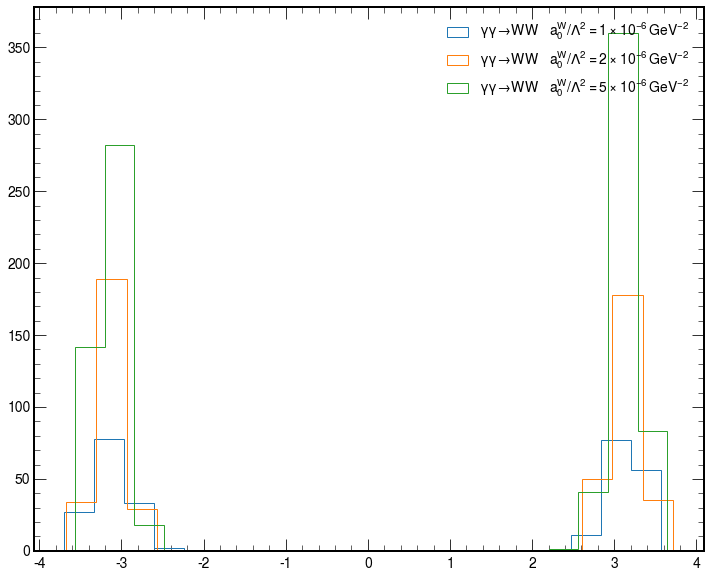

In [7]:
labels_samples = {
    "GGToWW-AQGC-A0W5e-7": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-7} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 1 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 2 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-6} \,\rm{GeV}^{-2}$"
}
labels_samples[ "GGToWW-AQGC-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]

if load_signal:
    fig = plt.figure( figsize=(12,10) )
    for label_ in labels_signals: 
        plt.hist( df_signals_protons_multiRP_events[ label_ ]["_nom"][ 'deltaPhi_jet_lep_nom' ], histtype='step', density=False, bins=20, label=labels_samples[ label_ ] )
    plt.legend( loc='best', fontsize=14 )

### MC (Bkg)

In [8]:
load_MC = True

labels_MC = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_MC = [ ]
    elif lepton_type == 'electron':
        labels_MC = [ ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_MC = [ "Bkg-2018-muon-QCD_Pt_170to300", "Bkg-2018-muon-QCD_Pt_300to470", "Bkg-2018-muon-QCD_Pt_470to600",
                      "Bkg-2018-muon-QCD_Pt_600to800","Bkg-2018-muon-QCD_Pt_800to1000", "Bkg-2018-muon-QCD_Pt_1000to1400",
                      "Bkg-2018-muon-QCD_Pt_1400to1800", "Bkg-2018-muon-QCD_Pt_1800to2400", "Bkg-2018-muon-QCD_Pt_2400to3200", "Bkg-2018-muon-QCD_Pt_3200toInf"
                    ]
    elif lepton_type == 'electron':
        labels_MC = [ "Bkg-2018-electron-QCD_Pt_170to300", "Bkg-2018-electron-QCD_Pt_300to470", "Bkg-2018-electron-QCD_Pt_470to600",
                      "Bkg-2018-electron-QCD_Pt_600to800","Bkg-2018-electron-QCD_Pt_800to1000", "Bkg-2018-electron-QCD_Pt_1000to1400",
                      "Bkg-2018-electron-QCD_Pt_1400to1800", "Bkg-2018-electron-QCD_Pt_1800to2400", "Bkg-2018-electron-QCD_Pt_2400to3200", "Bkg-2018-electron-QCD_Pt_3200toInf"
                    ]
    
df_counts_MC = {}
df_events_MC = {}
if load_MC:
    base_path_ = "output_events"
    for label_ in labels_MC:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )
            df_counts_MC[ label_ ] = store_[ "counts" ]
            print ( df_counts_MC[ label_ ] )
            df_events_MC[ label_ ] = store_[ "events" ]

Bkg-2018-electron-QCD_Pt_170to300
['/counts', '/events']
All           1166
Jet           1166
Electron       852
check_none     852
dtype: int64
Bkg-2018-electron-QCD_Pt_300to470
['/counts', '/events']
All           5056
Jet           5056
Electron      3705
check_none    3705
dtype: int64
Bkg-2018-electron-QCD_Pt_470to600
['/counts', '/events']
All           5184
Jet           5184
Electron      3877
check_none    3877
dtype: int64
Bkg-2018-electron-QCD_Pt_600to800
['/counts', '/events']
All           7362
Jet           7362
Electron      5684
check_none    5684
dtype: int64
Bkg-2018-electron-QCD_Pt_800to1000
['/counts', '/events']
All           4398
Jet           4398
Electron      3381
check_none    3381
dtype: int64
Bkg-2018-electron-QCD_Pt_1000to1400
['/counts', '/events']
All           2561
Jet           2561
Electron      1972
check_none    1972
dtype: int64
Bkg-2018-electron-QCD_Pt_1400to1800
['/counts', '/events']
All           1567
Jet           1567
Electron      1236
check

In [9]:
label_ref_ = ""
if data_sample == '2017':
    if lepton_type == 'muon':
        label_ref_ = ''
    elif lepton_type == 'electron':
        label_ref_ = ''
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_ref_ = 'Bkg-2018-muon-QCD_Pt_170to300'
    elif lepton_type == 'electron':
        label_ref_ = 'Bkg-2018-electron-QCD_Pt_170to300'


In [10]:
for label_ in labels_MC:
    jet0_tau21, rhoprime1, jet0_tau21_ddt = tau21_ddt_calculation(df_events_MC[ label_ ], lepton_type)
    print(jet0_tau21)
    df_events_MC[ label_ ][ "jet0_tau21" ] = jet0_tau21
    df_events_MC[ label_ ][ "jet0_tau21_nom" ] = jet0_tau21
    df_events_MC[ label_ ][ "jet0_tau21_ddt" ] = jet0_tau21_ddt
    df_events_MC[ label_ ][ "jet0_tau21_ddt_nom" ] = jet0_tau21_ddt

0      0.767440
1      0.881919
2      0.887129
3      0.870431
4      0.689323
         ...   
847    0.800882
848    0.804972
849    0.793752
850    0.528353
851    0.861877
Length: 852, dtype: float32
0       0.823221
1       0.739813
2       0.902254
3       0.895389
4       0.816029
          ...   
3700    0.744833
3701    0.871042
3702    0.866565
3703    0.795610
3704    0.661519
Length: 3705, dtype: float32
0       0.660045
1       0.368867
2       0.701075
3       0.872271
4       0.574704
          ...   
3872    0.553532
3873    0.846534
3874    0.822701
3875    0.780449
3876    0.588649
Length: 3877, dtype: float32
0       0.823963
1       0.888548
2       0.825259
3       0.854696
4       0.260875
          ...   
5679    0.727804
5680    0.411907
5681    0.721583
5682    0.872854
5683    0.925042
Length: 5684, dtype: float32
0       0.855733
1       0.503201
2       0.487196
3       0.763161
4       0.830070
          ...   
3376    0.573414
3377    0.583764
3378    0.52

In [11]:
print ( df_events_MC[ label_ref_ ].columns.values )

df_events_MC[ label_ref_ ]

['run' 'lumiblock' 'event' 'crossingAngle' 'betaStar' 'instLumi' 'jet0_pt'
 'jet0_eta' 'jet0_phi' 'jet0_energy' 'jet0_mass' 'jet0_corrmass'
 'jet0_tau1' 'jet0_tau2' 'jet0_vertexz' 'jet0_px' 'jet0_py' 'jet0_pz'
 'calo_met' 'met' 'met_x' 'met_y' 'met_phi' 'nVertices' 'num_bjets_ak8'
 'num_bjets_ak4' 'num_jets_ak4' 'pfcand_nextracks'
 'pfcand_nextracks_noDRl' 'recoMWhad' 'recoMWlep' 'recoMWlep_metJER_Up'
 'recoMWlep_metJER_Down' 'recoMWlep_metJES_Up' 'recoMWlep_metJES_Down'
 'recoMWW' 'recoMWW_metJER_Up' 'recoMWW_metJER_Down' 'recoMWW_metJES_Up'
 'recoMWW_metJES_Down' 'recoRapidityWW' 'dphiWW' 'WLeptonicPt'
 'WLeptonicPt_metJER_Up' 'WLeptonicPt_metJER_Down' 'WLeptonicPt_metJES_Up'
 'WLeptonicPt_metJES_Down' 'WLeptonicEta' 'WLeptonicPhi' 'electron0_pt'
 'electron0_eta' 'electron0_phi' 'electron0_energy' 'electron0_charge'
 'electron0_dxy' 'electron0_dz' 'electron0_corr'
 'electron0_ecalTrkEnPostCorr' 'electron0_ecalTrkEnErrPostCorr'
 'electron0_ecalTrkEnPreCorr' 'electron0_energyScaleValue

,run,lumiblock,event,crossingAngle,betaStar,instLumi,jet0_pt,jet0_eta,jet0_phi,jet0_energy,...,xiCMS_45_jes_dw,xiCMS_56_jes_dw,xiCMS_45_jer_up,xiCMS_56_jer_up,xiCMS_45_jer_dw,xiCMS_56_jer_dw,jet0_tau21,jet0_tau21_nom,jet0_tau21_ddt,jet0_tau21_ddt_nom
0,1,716,715262,152.0,0.4,0.0,376.571960,-1.756057,-0.398828,1125.003906,...,0.082962,0.174344,0.082676,0.164774,0.082955,0.174138,0.767440,0.767440,0.635121,0.635121
1,1,5662,5661452,152.0,0.4,0.0,285.387878,-1.470702,1.800753,656.474365,...,0.023459,0.094504,0.023556,0.096332,0.023567,0.096556,0.881919,0.881919,0.885052,0.885052
2,1,5633,5632213,152.0,0.4,0.0,225.552917,-1.922976,-2.215968,790.278198,...,0.004171,0.196348,0.004224,0.198828,0.004228,0.199022,0.887129,0.887129,0.881707,0.881707
3,1,7179,7178592,152.0,0.4,0.0,221.371048,0.893628,2.307684,321.104950,...,0.041764,0.024804,0.042036,0.024850,0.042197,0.024877,0.870431,0.870431,0.811050,0.811050
4,1,19837,19836928,152.0,0.4,0.0,292.351837,0.477580,-0.439799,337.769012,...,0.079366,0.018620,0.079641,0.018725,0.079545,0.018689,0.689323,0.689323,0.862861,0.862861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,1,29801,29800674,152.0,0.4,0.0,224.330154,-1.502169,0.952671,530.910889,...,0.005222,0.104999,0.005306,0.106698,0.005301,0.106596,0.800882,0.800882,0.818279,0.818279
848,1,29811,29810160,152.0,0.4,0.0,271.744446,1.566012,0.061328,681.666138,...,0.102135,0.029442,0.104172,0.029531,0.104203,0.029532,0.804972,0.804972,0.824099,0.824099
849,1,29918,29917460,156.0,0.4,0.0,209.124008,0.000003,0.303979,212.973572,...,0.028067,0.021848,0.028187,0.021967,0.028182,0.021963,0.793752,0.793752,0.774552,0.774552
850,1,29987,29986260,156.0,0.4,0.0,230.592911,-0.552259,-2.899862,274.513763,...,0.015416,0.038291,0.015493,0.038523,0.015481,0.038486,0.528353,0.528353,0.645552,0.645552


In [12]:
df_events_MC

{'Bkg-2018-electron-QCD_Pt_170to300':      run  lumiblock     event  crossingAngle  betaStar  instLumi     jet0_pt  \
 0      1        716    715262          152.0       0.4       0.0  376.571960   
 1      1       5662   5661452          152.0       0.4       0.0  285.387878   
 2      1       5633   5632213          152.0       0.4       0.0  225.552917   
 3      1       7179   7178592          152.0       0.4       0.0  221.371048   
 4      1      19837  19836928          152.0       0.4       0.0  292.351837   
 ..   ...        ...       ...            ...       ...       ...         ...   
 847    1      29801  29800674          152.0       0.4       0.0  224.330154   
 848    1      29811  29810160          152.0       0.4       0.0  271.744446   
 849    1      29918  29917460          156.0       0.4       0.0  209.124008   
 850    1      29987  29986260          156.0       0.4       0.0  230.592911   
 851    1      29896  29895288          152.0       0.4       0.0  283.5

In [13]:
labels_samples = {
    "Bkg-2018-muon-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
    "Bkg-2018-muon-QCD": r"QCD",
    "Bkg-2018-electron-QCD": r"QCD"
}

In [14]:
##var__ = "jet0_pt_nom"
##if load_MC:
##    fig = plt.figure( figsize=(12,10) )
##    for label__ in labels_MC: 
##        plt.hist( df_events_MC[ label__ ][ var__ ], histtype='step', density=False, bins=50, label=labels_samples[ label__ ] )
##    plt.legend( loc='best', fontsize=14 )

### Select events

In [15]:
df_selected_events_MC = {}

variations_ = { "jet": [ "_jes_up", "_jes_dw", "_jer_up", "_jer_dw" ] }
for label__ in labels_MC:
    print ( label__ )
    df_events__ = df_events_MC[ label__ ]
    print ( df_events__.shape[0] )
    df_selected_events__, selection_keys__, selections__, deltaR_jet_lep_  = select_events( df_events__, lepton_type )
    print ( df_selected_events__.shape[0] )
    print ( selection_keys__ )
    print ( selections__ )
    df_selected_events_MC[ label__ ] = {}
    df_selected_events_MC[ label__ ][ "_nom" ] = df_selected_events__
    for var_label__ in variations_:
        print ( var_label__ )
        for variation__ in variations_[ var_label__ ]:
            opt__ = { "label_" + var_label__ : variation__ }
            print ( opt__ )
            df_selected_events__, selection_keys__, selections__, deltaR_jet_lep_  = select_events( df_events__, lepton_type, **opt__ )
            print ( df_selected_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_selected_events_MC[ label__ ][ variation__ ] = df_selected_events__

Bkg-2018-electron-QCD_Pt_170to300
852
1
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 852, 'Electron': 852, 'Jet': 643, 'Jet_Electron': 627, 'MET': 11, 'Jet_MET': 7, 'PrunedMass': 1, 'BJet_Veto': 1, 'Xi_CMS': 1, 'WLeptonic': 1, 'Jet_WLeptonic': 1, 'MWW': 1, 'ExtraTracks': 1}
jet
{'label_jet': '_jes_up'}
1
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 852, 'Electron': 852, 'Jet': 675, 'Jet_Electron': 657, 'MET': 11, 'Jet_MET': 7, 'PrunedMass': 1, 'BJet_Veto': 1, 'Xi_CMS': 1, 'WLeptonic': 1, 'Jet_WLeptonic': 1, 'MWW': 1, 'ExtraTracks': 1}
{'label_jet': '_jes_dw'}
1
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 852, 'Electron': 852, 'Jet': 602, 'Jet_Electron'

7
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 3381, 'Electron': 3381, 'Jet': 3380, 'Jet_Electron': 3377, 'MET': 654, 'Jet_MET': 185, 'PrunedMass': 24, 'BJet_Veto': 23, 'Xi_CMS': 7, 'WLeptonic': 7, 'Jet_WLeptonic': 7, 'MWW': 7, 'ExtraTracks': 7}
{'label_jet': '_jer_dw'}
7
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 3381, 'Electron': 3381, 'Jet': 3380, 'Jet_Electron': 3377, 'MET': 654, 'Jet_MET': 185, 'PrunedMass': 24, 'BJet_Veto': 23, 'Xi_CMS': 7, 'WLeptonic': 7, 'Jet_WLeptonic': 7, 'MWW': 7, 'ExtraTracks': 7}
Bkg-2018-electron-QCD_Pt_1000to1400
1972
5
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1972, 'Electron': 1972, 'Jet': 1972, 'Jet_Electron': 197

In [16]:
df_selected_events_MC

{'Bkg-2018-electron-QCD_Pt_170to300': {'_nom':      run  lumiblock     event  crossingAngle  betaStar  instLumi     jet0_pt  \
  182    1      17448  17447636          156.0       0.4       0.0  241.962509   
  
       jet0_eta  jet0_phi  jet0_energy  ...  xiCMS_45_jes_dw  xiCMS_56_jes_dw  \
  182  1.398802 -2.085036   526.139099  ...         0.161445         0.010641   
  
       xiCMS_45_jer_up  xiCMS_56_jer_up  xiCMS_45_jer_dw  xiCMS_56_jer_dw  \
  182         0.162041         0.010678         0.162278         0.010692   
  
       jet0_tau21  jet0_tau21_nom  jet0_tau21_ddt  jet0_tau21_ddt_nom  
  182    0.564006        0.564006        0.748736            0.748736  
  
  [1 rows x 251 columns],
  '_jes_up':      run  lumiblock     event  crossingAngle  betaStar  instLumi     jet0_pt  \
  182    1      17448  17447636          156.0       0.4       0.0  241.962509   
  
       jet0_eta  jet0_phi  jet0_energy  ...  xiCMS_45_jes_dw  xiCMS_56_jes_dw  \
  182  1.398802 -2.085036   526.13

In [17]:
import json
samples_info = None
if data_sample == '2017':
    pass
elif data_sample == '2018':
    samples_info = json.load( open( 'samples_info_UL18_XSDB.json' ) )
samples_info

{'FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0': [100000.0, 0.045393, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0': [100000.0, 0.058313, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0': [100000.0, 0.148122, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_2e-5_semi_pt0': [99000.0, 0.16477, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_5e-6_semi_pt0': [100000.0, 0.049199, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_8e-6_semi_pt0': [100000.0, 0.061404, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_0_semi_pt0': [262999.0, 0.0409705, 1.0, 6],
 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8': [306142140.0, 831.76, 1.0, 800],
 'WW_TuneCP5_13TeV-pythia8': [15679000.0, 75.95, 1.0, 800],
 'WZ_TuneCP5_13TeV-pythia8': [7940000.0, 27.59, 1.0, 800],
 'ZZ_TuneCP5_13TeV-pythia8': [3526000.0, 12.17, 1.0, 800],
 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8': [19366000.0,
  3.549,
  1.0,
  800],
 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8': [178756000.0,
  115.3,
  1.0,
  800],

In [18]:
sample_names = {}
if data_sample == '2017':
    pass
elif data_sample == '2018':
    sample_names[ "Bkg-2018-muon-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'


In [19]:
lumi_periods = None
if data_sample == '2017':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2017[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2017[ 'electron' ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2018[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2018[ 'electron' ]
    
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )
    
norm_factors = {}
for label__ in labels_MC:
    print ( label__ )
    print ( samples_info[ sample_names[ label__ ] ] )
    sample_nevents_, sample_cross_section_, sel_eff_, _ = samples_info[ sample_names[ label__ ] ]
    sample_cross_section_ = sample_cross_section_ * sel_eff_
#     if norm_to_1fb:
#         sample_cross_section_ = 1.e-03
    print ( sample_cross_section_ )
    norm_factors[ label__ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( norm_factors[ label__ ] )
    norm_factors_product_ = np.product( norm_factors[ label__ ] )
    print ( norm_factors_product_ )
    if df_selected_events_MC[ label__ ][ "_nom" ].shape[0] > 0:
        df_selected_events_MC[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
    for variation__ in df_selected_events_MC[ label__ ]:
        print ( variation__ )
        if df_selected_events_MC[ label__ ][ variation__ ].shape[0] > 0:
            df_selected_events_MC[ label__ ][ variation__ ].loc[ :, "norm" ] = norm_factors_product_

55.702914022
Bkg-2018-electron-QCD_Pt_170to300
[29676000.0, 103700, 1.0, 800]
103700.0
[1.87703579e-06 1.03700000e+08 1.00000000e+00]
194.64861113631892
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-electron-QCD_Pt_300to470
[57910000.0, 6830, 1.0, 800]
6830.0
[9.61887654e-07 6.83000000e+06 1.00000000e+00]
6.569692674326713
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-electron-QCD_Pt_470to600
[52448000.0, 551.2, 1.0, 800]
551.2
[1.06205983e-06 5.51200000e+05 1.00000000e+00]
0.58540737890723
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-electron-QCD_Pt_600to800
[67508000.0, 156.7, 1.0, 800]
156.7
[8.25130563e-07 1.56700000e+05 1.00000000e+00]
0.12929795916406056
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-electron-QCD_Pt_800to1000
[37160000.0, 26.25, 1.0, 800]
26.25
[1.49900199e-06 2.62500000e+04 1.00000000e+00]
0.03934880228949139
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-electron-QCD_Pt_1000to1400
[19730000.0, 7.465, 1.0, 800]
7.465
[2.82325971e-06 7.46500000e+03 1.00000000e+00]

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [20]:
var_name__ = ""
if lepton_type == 'muon':
    var_name__ = "sf_muon_id"
elif lepton_type == 'electron':
    var_name__ = "sf_electron_id"
var_name_up__ = var_name__ + "_up"
var_name_dw__ = var_name__ + "_dw"

df_selected_events_MC[ "Bkg-2018-"+lepton_type+"-QCD_Pt_170to300" ][ "_nom" ][ [ var_name__, var_name_up__, var_name_dw__ ] ]

,sf_electron_id,sf_electron_id_up,sf_electron_id_dw
182,0.997698,1.009353,0.986044


In [21]:
df_selected_events_MC[ "Bkg-2018-"+lepton_type+"-QCD_Pt_170to300" ][ "_nom" ][ [ "pileupWeight" ] ]

,pileupWeight
182,1.03718


In [22]:
label_WJetsToLNu = ''
samples_WJetsToLNu = []
label_DYJetsToLL = ''
samples_DYJetsToLL = []
label_QCD = ''
samples_QCD = []
label_ST = ''
samples_ST = []
label_VV = ''
samples_VV = []
if data_sample == '2017':
    if lepton_type == 'muon':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
    elif lepton_type == 'electron':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_QCD = "Bkg-2018-muon-QCD"
        samples_QCD = [ "Bkg-2018-muon-QCD_Pt_170to300", "Bkg-2018-muon-QCD_Pt_300to470", "Bkg-2018-muon-QCD_Pt_470to600",
                        "Bkg-2018-muon-QCD_Pt_600to800","Bkg-2018-muon-QCD_Pt_800to1000", "Bkg-2018-muon-QCD_Pt_1000to1400",
                        "Bkg-2018-muon-QCD_Pt_1400to1800", "Bkg-2018-muon-QCD_Pt_1800to2400", "Bkg-2018-muon-QCD_Pt_2400to3200", "Bkg-2018-muon-QCD_Pt_3200toInf" ]
    elif lepton_type == 'electron':
        label_QCD = "Bkg-2018-electron-QCD"
        samples_QCD = [ "Bkg-2018-electron-QCD_Pt_170to300", "Bkg-2018-electron-QCD_Pt_300to470", "Bkg-2018-electron-QCD_Pt_470to600",
                        "Bkg-2018-electron-QCD_Pt_600to800","Bkg-2018-electron-QCD_Pt_800to1000", "Bkg-2018-electron-QCD_Pt_1000to1400",
                        "Bkg-2018-electron-QCD_Pt_1400to1800", "Bkg-2018-electron-QCD_Pt_1800to2400", "Bkg-2018-electron-QCD_Pt_2400to3200", "Bkg-2018-electron-QCD_Pt_3200toInf" ]

df_selected_events_MC[ label_QCD ] = {}

for variation__ in df_selected_events_MC[ samples_QCD[ 0 ] ]:
    print ( variation__ )
    df_events_list__ = []
    for label__ in samples_QCD:
        df_events_list__.append( df_selected_events_MC[ label__ ][ variation__ ] )
    df_selected_events_MC[ label_QCD ][ variation__ ] = pd.concat( df_events_list__ )

labels_MC.append( label_QCD )

_nom
_jes_up
_jes_dw
_jer_up
_jer_dw


In [23]:
df_selected_events_MC[ label_QCD ]

{'_nom':       run  lumiblock     event  crossingAngle  betaStar  instLumi  \
 182     1      17448  17447636          156.0       0.4       0.0   
 89      1      49173  49172156          156.0       0.4       0.0   
 151     1      12167  12166020          130.0       0.4       0.0   
 198     1      31001  31000292          156.0       0.4       0.0   
 1661    1       8107   8106133          153.0       0.4       0.0   
 1819    1      11535  11534925          152.0       0.4       0.0   
 2840    1      34653  34652108          152.0       0.4       0.0   
 2941    1      37026  37025864          156.0       0.4       0.0   
 393     1      17954  17953270          152.0       0.4       0.0   
 3050    1      33493  33492282          156.0       0.4       0.0   
 247     1       7264   7263482          135.0       0.4       0.0   
 460     1      11320  11319122          130.0       0.4       0.0   
 510     1      12188  12187775          152.0       0.4       0.0   
 1513    1  

In [24]:
jet0_tau21_QCD, rhoprime1_QCD, jet0_tau21_ddt_QCD = tau21_ddt_calculation(df_selected_events_MC[ label_QCD ][ "_nom" ], lepton_type)
print(jet0_tau21_QCD)
print(rhoprime1_QCD)
print(jet0_tau21_ddt_QCD)

182     0.564006
89      0.752630
151     0.467494
198     0.611423
1661    0.627522
1819    0.632410
2840    0.480448
2941    0.326661
393     0.789917
3050    0.710459
247     0.717159
460     0.270999
510     0.401637
1513    0.395483
1725    0.694353
2337    0.563452
4099    0.682645
4126    0.542616
4468    0.552618
4743    0.506616
975     0.535093
1574    0.678982
1835    0.536725
2302    0.548788
2307    0.668500
3215    0.365818
3264    0.638729
467     0.709982
629     0.569956
1498    0.727386
1580    0.441251
1789    0.805855
30      0.517875
dtype: float32
182     3.191724
89      2.279606
151     2.588372
198     3.013116
1661    3.066718
1819    3.636512
2840    2.578265
2941    2.258759
393     2.594573
3050    1.830093
247     2.464906
460     3.133221
510     2.708052
1513    2.542674
1725    1.816880
2337    2.926882
4099    1.477883
4126    2.007578
4468    1.900341
4743    1.922419
975     2.395592
1574    1.571709
1835    1.616234
2302    1.201723
2307    0.944875

In [25]:
variations_weights_ = [ "nom" ]

if lepton_type == 'muon':
    variations_weights_sf_muon_id_ = [ "sf_muon_id_up", "sf_muon_id_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_id_ )
    variations_weights_sf_muon_trigger_ = [ "sf_muon_trigger_up", "sf_muon_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_trigger_ )
elif lepton_type == 'electron':
    variations_weights_sf_electron_id_ = [ "sf_electron_id_up", "sf_electron_id_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_id_ )
    variations_weights_sf_electron_trigger_ = [ "sf_electron_trigger_up", "sf_electron_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_trigger_ )

variations_weights_sf_prefiring_ = [ "sf_prefiring_up", "sf_prefiring_dw" ]
variations_weights_.extend( variations_weights_sf_prefiring_ )    
    
var_names_sf_lepton_id__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_muon_id"
    var_names_sf_lepton_id__[ "sf_muon_id_up" ] = "sf_muon_id_up"
    var_names_sf_lepton_id__[ "sf_muon_id_dw" ] = "sf_muon_id_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_electron_id"
    var_names_sf_lepton_id__[ "sf_electron_id_up" ] = "sf_electron_id_up"
    var_names_sf_lepton_id__[ "sf_electron_id_dw" ] = "sf_electron_id_dw"
    
var_names_sf_trigger__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_id_up", "sf_muon_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_muon_trigger"
    var_names_sf_trigger__[ "sf_muon_trigger_up" ] = "sf_muon_trigger_up"
    var_names_sf_trigger__[ "sf_muon_trigger_dw" ] = "sf_muon_trigger_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_id_up", "sf_electron_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_electron_trigger"
    var_names_sf_trigger__[ "sf_electron_trigger_up" ] = "sf_electron_trigger_up"
    var_names_sf_trigger__[ "sf_electron_trigger_dw" ] = "sf_electron_trigger_dw"

var_names_sf_prefiring__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_muon_id_up", "sf_muon_id_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_electron_id_up", "sf_electron_id_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight"
var_names_sf_prefiring__[ "sf_prefiring_up" ] = "prefiring_weight_up"
var_names_sf_prefiring__[ "sf_prefiring_dw" ] = "prefiring_weight_down"
    
print ( variations_weights_ )
print ( var_names_sf_lepton_id__ )
print ( var_names_sf_trigger__ )
print ( var_names_sf_prefiring__ )

weights_events_MC = {}
for label__ in labels_MC:
    print ( label__ )
    
    weights_events_MC[ label__ ] = {}
    for var_weights__ in variations_weights_:
        weights_events_MC[ label__ ][ var_weights__ ] = {}
        for variation__ in df_selected_events_MC[ label__ ]:
            df_selected_events__ = df_selected_events_MC[ label__ ][ variation__ ]
            if df_selected_events__.shape[0] > 0:
                weights_events_MC[ label__ ][ var_weights__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                 df_selected_events__[ "pileupWeight" ] *
                                                                                 df_selected_events__[ var_names_sf_lepton_id__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_trigger__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_prefiring__[ var_weights__ ] ] )

print ( weights_events_MC )

['nom', 'sf_electron_id_up', 'sf_electron_id_dw', 'sf_electron_trigger_up', 'sf_electron_trigger_dw', 'sf_prefiring_up', 'sf_prefiring_dw']
{'nom': 'sf_electron_id', 'sf_prefiring_up': 'sf_electron_id', 'sf_prefiring_dw': 'sf_electron_id', 'sf_electron_trigger_up': 'sf_electron_id', 'sf_electron_trigger_dw': 'sf_electron_id', 'sf_electron_id_up': 'sf_electron_id_up', 'sf_electron_id_dw': 'sf_electron_id_dw'}
{'nom': 'sf_electron_trigger', 'sf_prefiring_up': 'sf_electron_trigger', 'sf_prefiring_dw': 'sf_electron_trigger', 'sf_electron_id_up': 'sf_electron_trigger', 'sf_electron_id_dw': 'sf_electron_trigger', 'sf_electron_trigger_up': 'sf_electron_trigger_up', 'sf_electron_trigger_dw': 'sf_electron_trigger_dw'}
{'nom': 'prefiring_weight', 'sf_electron_id_up': 'prefiring_weight', 'sf_electron_id_dw': 'prefiring_weight', 'sf_electron_trigger_up': 'prefiring_weight', 'sf_electron_trigger_dw': 'prefiring_weight', 'sf_prefiring_up': 'prefiring_weight_up', 'sf_prefiring_dw': 'prefiring_weight_

### Plot MC

BinnedStatisticResult(statistic=array([[0.        , 0.72318709, 4.30801409, 5.65956473, 4.31439543,
        4.53383273, 2.7919122 , 0.84288293, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.      

/tmp/ipykernel_1373/716351346.py:17: RuntimeWarning: invalid value encountered in true_divide
  mean_y_binned  = ( sum_y_binned / count_y_binned )
/tmp/ipykernel_1373/716351346.py:18: RuntimeWarning: invalid value encountered in true_divide
  mean_y2_binned = ( sum_y2_binned / count_y_binned )
/tmp/ipykernel_1373/716351346.py:20: RuntimeWarning: invalid value encountered in sqrt
  stddev_binned_ddof1 = stddev_binned * np.sqrt( count_y_binned ) / np.sqrt( count_y_binned - 1 )
/tmp/ipykernel_1373/716351346.py:20: RuntimeWarning: divide by zero encountered in true_divide
  stddev_binned_ddof1 = stddev_binned * np.sqrt( count_y_binned ) / np.sqrt( count_y_binned - 1 )


2.4011781013548375e-09
0.7022360511252201


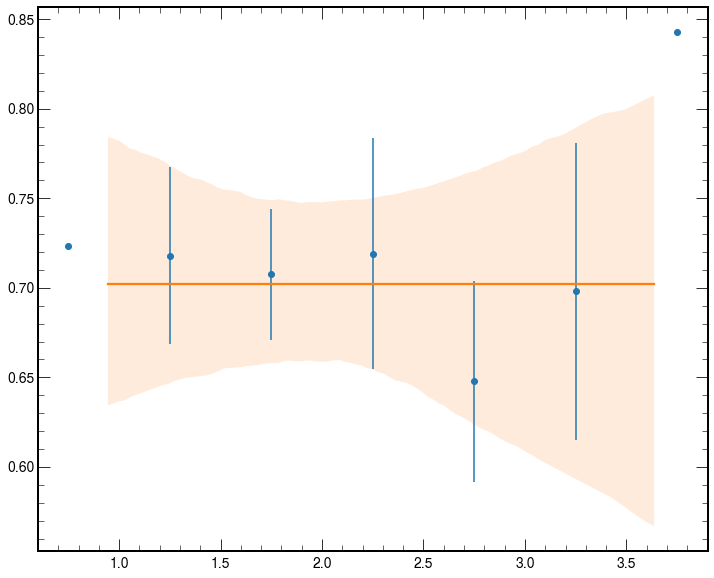

In [26]:
import seaborn as sns

def profile( x, y, bins, range ):
    binned_sums = scipy.stats.binned_statistic(x, [y, y**2], bins=bins, range=range, statistic='sum')
    print ( binned_sums )
    binned_counts = scipy.stats.binned_statistic(x, y, bins=bins, range=range, statistic='count')
    print ( binned_counts )

    bin_edges = binned_sums.bin_edges
    bin_centers = ( bin_edges[:-1] + bin_edges[1:] ) / 2

    sum_y_binned    = binned_sums.statistic[ 0 ]
    sum_y2_binned   = binned_sums.statistic[ 1 ]
    count_y_binned  = binned_counts.statistic
    print ( sum_y_binned, sum_y2_binned, count_y_binned )

    mean_y_binned  = ( sum_y_binned / count_y_binned )
    mean_y2_binned = ( sum_y2_binned / count_y_binned )
    stddev_binned  = np.sqrt( mean_y2_binned - mean_y_binned ** 2 )
    stddev_binned_ddof1 = stddev_binned * np.sqrt( count_y_binned ) / np.sqrt( count_y_binned - 1 )
    err_mean_y_binned = stddev_binned_ddof1 / np.sqrt( count_y_binned )
    print ( mean_y_binned, mean_y2_binned, stddev_binned, stddev_binned_ddof1, err_mean_y_binned )

    return ( bin_centers, mean_y_binned, stddev_binned_ddof1, err_mean_y_binned )

# Data
x = rhoprime1_QCD
y = jet0_tau21_QCD

bins = 100
range = (0.,50.)

bin_centers, mean_y_binned, stddev_binned_ddof1, err_mean_y_binned = profile( x, y, bins=bins, range=range )

fig = plt.figure( figsize=(12,10) )
plt.errorbar(x=bin_centers, y=mean_y_binned, yerr=err_mean_y_binned, linestyle='none', marker='o')
plt.xlabel( r"$\rho '$", fontsize=18 )
plt.ylabel( r"$\tau_{21_ddt}$", fontsize=18 )
sns.regplot(x=x, y=y, scatter=False)
slope, intercept, r, p, se = scipy.stats.linregress(x, y)
print(slope)
print(intercept)